In [3]:
import torch
import random
from d2l import torch as d2l

In [13]:
def synthetic_data(w,b, num_examples):
    X=torch.normal(0,1,(num_examples,len(w)))    # 1000x3正态分布的随机数
    Y=torch.matmul(X,w)+b  # 矩阵相乘
    Y+=torch.normal(0,0.01,Y.shape)
    return X,Y.reshape((-1,1))  # Y转化为列向量

In [14]:
true_w=torch.tensor([2,-3.4])
true_b=4.2
features,labels=synthetic_data(true_w,true_b,1000)

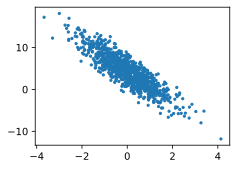

In [15]:
2l.set_figsize()  # 参数5表示图像点的大小
d2l.plt.scatter(features[:,(1)].detach().numpy(),labels.detach().numpy(),5);      # detach就是把网络中的一部分分量从反向传播的流程中拿出来

In [16]:
def data_iter(batch_size,features,labels):
    num_examples=len(features)
    indices=list(range(num_examples))   # 生成0-n-1的数，并转化为列表
    #这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices) 
    for i in range(0,num_examples,batch_size):
        batch_indices=torch.tensor(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]   # return返回的是一个list列表，而yield每次调用只返回一个数值，
        #毫无疑问，使用return空间开销比较大，尤其是操作巨量数据的时候，操作一个大列表时间开销也会得不偿失
batch_size=10
for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break

tensor([[ 0.9832,  0.8753],
        [ 0.3084,  1.8021],
        [ 1.4728, -0.7156],
        [-1.2729,  1.3295],
        [-0.6765, -0.9041],
        [-0.8582,  0.4715],
        [-0.6118,  0.8325],
        [ 0.5744, -0.9288],
        [-0.3760,  0.1834],
        [-0.9019, -1.6200]]) 
 tensor([[ 3.1754],
        [-1.3028],
        [ 9.5747],
        [-2.8570],
        [ 5.9272],
        [ 0.8750],
        [ 0.1488],
        [ 8.5177],
        [ 2.8221],
        [ 7.9001]])


In [17]:
#定义初始化模型参数
w=torch.normal(0,0.01,size=(2,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)
def linreg(X,w,b):
    """线性回归模型"""
    return torch.matmul(X,w)+b

def squared_loss(y_hat,y):
    """均方损失"""
    return(y_hat-y.reshape(y_hat.shape))**2/2
# 定义优化算法
def sgd(params,lr,batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param-=lr*param.grad/batch_size  # 除以总的样本
            param.grad.zero_()
lr=0.001
num_epochs=3
net=linreg
loss=squared_loss
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l=loss(net(X,w,b),y)   # ‘X’和'y'的小批量损失
        #因为'l'的形状是('batch_size',l)，而不是一个标量。'l'中的所有元素被加到
        # 并以此计算关于['w','b']的梯度
        l.sum().backward()
        sgd([w,b],lr,batch_size)    # 使用参数的梯度更新
    with torch.no_grad():  #  强制之后的内容不进行计算图构建
        train_l=loss(net(features,w,b),labels)
        print(f'epoch{epoch+1},loss{float(train_l.mean()):f}')

epoch1,loss13.817019
epoch2,loss11.252771
epoch3,loss9.164834


In [12]:
# 比较真实参数和通过训练学到的参数来评估训练的成功程度
print(f'w的估计误差：{true_w-w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b-b}')

w的估计误差：tensor([ 1.4405, -2.4903], grad_fn=<SubBackward0>)
b的估计误差：tensor([3.1222], grad_fn=<RsubBackward1>)


In [18]:
#线性回归的简洁实现
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l
true_w=torch.tensor([2,-3.4])
true_b=4.2
features,labels=d2l.synthetic_data(true_w,true_b,1000)

#调用框架中现有的API来读取数据
def load_array(data_arrays,batch_size,is_train=True):
    """构造一个pytorch数据迭代器"""
    dataset=data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset,batch_size,shuffle=is_train)   # shuffle是否随机分布
batch_size=10
data_iter=load_array((features,labels),batch_size)
next(iter(data_iter))   # 它通过调用其next ()方法从迭代器中检索下一个项目。

[tensor([[-1.1371, -0.3952],
         [ 0.9041,  0.4187],
         [ 2.2055,  1.3564],
         [-0.5134,  0.4508],
         [-1.3277,  1.6413],
         [ 1.8338, -0.0611],
         [-1.3035,  1.0071],
         [ 1.0475, -0.8159],
         [-1.2661,  1.2151],
         [-0.3023,  0.9251]]),
 tensor([[ 3.2340],
         [ 4.6068],
         [ 3.9855],
         [ 1.6430],
         [-4.0454],
         [ 8.0807],
         [-1.8375],
         [ 9.0776],
         [-2.4675],
         [ 0.4391]])]

In [ ]:
# 使用框架预定义好的层
# 'nn'是神经网络的缩写   以下这几行代码相当于之前手动设置w 和 b
from torch import nn
net=nn.Sequential(nn.Linear(2,1))   # 放到容器里
# 初始化模型参数
net[0].weight.data.normal_(0,0.01)  #使用正态分布替换掉data
net[0].bias.data.fill_(0)
#均方误差MSELoss类 ，也称为平方L2范数
loss=nn.MSELoss()
# 实例化SGD实例
trainer=torch.optim.SGD(net.parameters(),lr=0.03)
# 训练过程代码
num_epochs=3
for epoch in range(num_epochs):
    for X,y in data_iter:
        l=loss(net(X),y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l=loss(net(features),labels)   # 所有的特征和标签放进去，计算损失
    print(f'epoch{epoch+1},loss{l:f}')

In [ ]:
问题：为啥使用平方损失而不是绝对差值   因为平方损失可以导
问题：损失为什么要求平均 ？    如果梯度没有除n，学习率/n就行了
问题：用N-1代替n求误差是否可行       可行
问题：batchsize是否会最终影响模型结果？batchsize过小是否可能导致最终累积的梯度计算不准确？   batchsize越小越好，代表着噪音的学习效果
问题：每次都是随机取出一部分，怎么保证最后所有数据都被拿过了？  先打乱顺序，然后顺序取索引
问题：使用SGD，是因为大部分的实际LOSS太复杂，推导不出导数为0的解？只能逐个batch去逼近？     是的，只有线性回归有显式解。
问题:l.bachward()这里是调用pytorch自定义的back propogation吗？是的
问题：每个batch计算的时候，为什么需要把梯度先清零？  因为pytorch不帮忙清零